# A5: Sentence Embedding with BERT
Name: Sitthiwat Damrongpreechar <br>
Student ID: st123994

# BERT

## 0. Import Libraries

In [1]:
import math
import re
from random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
# Device setting
device = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
print(device)

cuda


## 1. Load data

This is the link for dataset: https://huggingface.co/datasets/d0rj/wikisum. The dataset is involve with the wikipedia summarization.

In [3]:
from datasets import load_dataset

dataset = load_dataset("d0rj/wikisum")

In [4]:
#!python -m spacy download en_core_web_md

In [5]:
dataset['train'][0]

{'url': 'https://www.wikihow.com/Store-Fresh-Oysters',
 'title': 'How to Store Fresh Oysters',
 'summary': "To store fresh oysters, start by placing un-shucked oysters on top of a layer of ice in a bowl. Next, lay a damp towel on top of the bowl and place it in your refrigerator set to 35° to 40° Fahrenheit. Make sure that the towel stays damp and replace the ice as needed. Then, shuck and eat the oysters within 2 days. If your oysters are already shucked or you need to store them for more than 2 days, place them in the freezer until you're ready to use them.",
 'article': "Do not shuck or wash your oysters. Oysters taste best when you shuck them immediately before eating them. In addition, keeping oysters in their shells makes them easier to store and reduces the chance that they'll go bad. If your oysters came pre-shucked in a plastic container, store them in the freezer until you're ready to use them. Leave the grit and dirt on the oysters. This will keep them moist and will help to

In [6]:
raw_texts = dataset['train'][:100]['article']
print(len(raw_texts))
raw_texts[:5]

100


["Do not shuck or wash your oysters. Oysters taste best when you shuck them immediately before eating them. In addition, keeping oysters in their shells makes them easier to store and reduces the chance that they'll go bad. If your oysters came pre-shucked in a plastic container, store them in the freezer until you're ready to use them. Leave the grit and dirt on the oysters. This will keep them moist and will help to insulate the meat. Pour ice into a small bowl or other open-top container. Grab a bowl, small cooler, or similar container that you can place inside your fridge. Make sure this container has an open top or removable lid. Then, pour a layer of ice into the bottom of the container. Do not keep your oysters in a sealed or closed-top container. Doing so will suffocate them. You may need to change your ice during the refrigeration process, so do not pour any into the container if you won't be able to check your oysters regularly. Place your oysters on top of the ice bed deep s

In [7]:
joined_dataset = '\n'.join(dataset['train'][:1]['article'])
joined_dataset

"Do not shuck or wash your oysters. Oysters taste best when you shuck them immediately before eating them. In addition, keeping oysters in their shells makes them easier to store and reduces the chance that they'll go bad. If your oysters came pre-shucked in a plastic container, store them in the freezer until you're ready to use them. Leave the grit and dirt on the oysters. This will keep them moist and will help to insulate the meat. Pour ice into a small bowl or other open-top container. Grab a bowl, small cooler, or similar container that you can place inside your fridge. Make sure this container has an open top or removable lid. Then, pour a layer of ice into the bottom of the container. Do not keep your oysters in a sealed or closed-top container. Doing so will suffocate them. You may need to change your ice during the refrigeration process, so do not pour any into the container if you won't be able to check your oysters regularly. Place your oysters on top of the ice bed deep si

## 2. Preprocessing

### 2.1 Tokenization and Numericalization

In [8]:
import spacy
nlp = spacy.load("en_core_web_md")
doc = nlp(joined_dataset)
sentences = list(doc.sents)
if len(sentences)>10:
    sentences = sentences[:10].copy()
# lowercase the text
text = [sent.text.lower() for sent in sentences]
# Remove the symbols
text = [re.sub("[.,!?\\-]", '', x) for x in text]


In [9]:
print(sentences[:1],len(sentences))
print(text[:1],len(text))

[Do not shuck or wash your oysters.] 10
['do not shuck or wash your oysters'] 10


### 2.2 Making Vocabs

In [10]:
# combine everything into one to make vocabs
word_list = list(set(" ".join(text).split()))
word2id = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}  #special tokens.

#create the word2id
for i, w in enumerate(word_list):
    word2id[w] = i + 4  #because 0-3 are already occupied
id2word = {i: w for i, w in enumerate(word2id)}
vocab_size = len(word2id)

#list of all tokens for whole text
token_list = list()
for sentence in sentences:
    arr = [word2id[word] for sentence in text for word in sentence.split()]
    token_list.append(arr)

In [11]:
# print
print('token_list: ',len(token_list))
print('word_list:',word_list[:5],len(word_list))
print('vocab_size', vocab_size)

token_list:  10
word_list: ['your', 'preshucked', 'not', 'makes', 'wash'] 80
vocab_size 84


In [12]:
for i in word_list[:5]:
    print(word2id[i])

4
5
6
7
8


In [13]:
# save all of these
import pickle
with open('./word2id.pickle','wb') as f:
  pickle.dump(word2id, f)
with open('./id2word.pickle','wb') as f:
  pickle.dump(id2word, f)
with open('./token_list.pickle','wb') as f:
  pickle.dump(token_list, f)

## 3. Data Loader

In [14]:
batch_size = 6
max_mask   = 5 #even though it does not reach 15% yet....maybe you can set this threshold
max_len    = 300 #maximum length that my transformer will accept.....all sentence will be padded

In [15]:
def make_batch():
    batch = []
    positive = negative = 0
    while positive != batch_size / 2 or negative != batch_size / 2:

        #randomly choose two sentence
        tokens_a_index, tokens_b_index = randrange(len(sentences)), randrange(len(sentences))
        tokens_a, tokens_b            = token_list[tokens_a_index], token_list[tokens_b_index]

        #1. token embedding - add CLS and SEP
        input_ids = [word2id['[CLS]']] + tokens_a + [word2id['[SEP]']] + tokens_b + [word2id['[SEP]']]

        #2. segment embedding - which sentence is 0 and 1
        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        #3 masking
        n_pred = min(max_mask, max(1, int(round(len(input_ids) * 0.15))))
        #get all the pos excluding CLS and SEP
        candidates_masked_pos = [i for i, token in enumerate(input_ids) if token != word2id['[CLS]']
                                 and token != word2id['[SEP]']]
        shuffle(candidates_masked_pos)
        masked_tokens, masked_pos = [], []
        #simply loop and mask accordingly
        for pos in candidates_masked_pos[:n_pred]:
            masked_pos.append(pos)
            masked_tokens.append(input_ids[pos])
            if random() < 0.1:  #10% replace with random token
                index = randint(0, vocab_size - 1)
                input_ids[pos] = word2id[id2word[index]]
            elif random() < 0.8:  #80 replace with [MASK]
                input_ids[pos] = word2id['[MASK]']
            else:
                pass

        #4. pad the sentence to the max length
        n_pad = max_len - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        #5. pad the mask tokens to the max length
        if max_mask > n_pred:
            n_pad = max_mask - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        #6. check whether is positive or negative
        if tokens_a_index + 1 == tokens_b_index and positive < batch_size / 2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True])
            positive += 1
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size / 2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False])
            negative += 1

    return batch


In [16]:
batch = make_batch()
len(batch)

6

In [17]:
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))
input_ids.shape, segment_ids.shape, masked_tokens.shape, masked_pos.shape, isNext

(torch.Size([6, 300]),
 torch.Size([6, 300]),
 torch.Size([6, 5]),
 torch.Size([6, 5]),
 tensor([1, 0, 0, 0, 1, 1]))

In [18]:
masked_tokens

tensor([[25, 33, 49, 48, 47],
        [ 8, 39, 63,  7, 60],
        [49, 18, 49, 24, 46],
        [ 9, 54, 65, 76, 63],
        [67, 48,  4, 81, 53],
        [ 9, 80, 46, 76, 81]])

## 4. BERT Model

### 4.1 Embedding Model

In [19]:
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(max_len, d_model)      # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, seg):
        #x, seg: (bs, len)
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long)
        pos = pos.unsqueeze(0).expand_as(x)  # (len,) -> (bs, len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

### 4.2 Attention Mask

In [20]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

Testing Attention Mask

In [21]:
print(get_attn_pad_mask(input_ids, input_ids).shape)

torch.Size([6, 300, 300])


### 4.3 Encoder

In [22]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn       = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

In [23]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
  
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k)
        scores.masked_fill_(attn_mask, -1e9)
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn 

In [24]:
n_layers = 6    # number of Encoder of Encoder Layer
n_heads  = 8    # number of heads in Multi-Head Attention
d_model  = 768  # Embedding Size
d_ff = 768 * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2

In [25]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(n_heads * d_v, d_model)(context)
        return nn.LayerNorm(d_model)(output + residual), attn # output: [batch_size x len_q x d_model]


In [26]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(F.gelu(self.fc1(x)))

### 4.4 Putting them together

In [27]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.embedding = Embedding()
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)


        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]

        # 1. predict next sentence
        # it will be decided by first token(CLS)
        h_pooled   = self.activ(self.fc(output[:, 0])) # [batch_size, d_model]
        logits_nsp = self.classifier(h_pooled) # [batch_size, 2]

        # 2. predict the masked token
        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked  = self.norm(F.gelu(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_nsp, h_pooled
    
    def get_last_hidden_state(self, input_ids, segment_ids):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        return output

## 5. Training

In [28]:
num_epoch = 10
model = BERT()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.004)
bert_loss = []
batch = make_batch()
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

for epoch in tqdm(range(num_epoch)):
    optimizer.zero_grad()
    logits_lm, logits_nsp, _ = model(input_ids, segment_ids, masked_pos)
    #logits_lm: (bs, max_mask, vocab_size) ==> (6, 5, 34)
    #logits_nsp: (bs, yes/no) ==> (6, 2)

    #1. mlm loss
    #logits_lm.transpose: (bs, vocab_size, max_mask) vs. masked_tokens: (bs, max_mask)
    loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
    loss_lm = (loss_lm.float()).mean()
    #2. nsp loss
    #logits_nsp: (bs, 2) vs. isNext: (bs, )
    loss_nsp = criterion(logits_nsp, isNext) # for sentence classification

    #3. combine loss
    loss = loss_lm + loss_nsp
    bert_loss.append(loss)
    
    if epoch % 10 == 0:
        print('Epoch:', '%02d' % (epoch), 'loss =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 00 loss = 60.859940


100%|██████████| 10/10 [00:24<00:00,  2.50s/it]


In [29]:
bert_loss = [i.detach().numpy() for i in bert_loss]

Text(0, 0.5, 'loss')

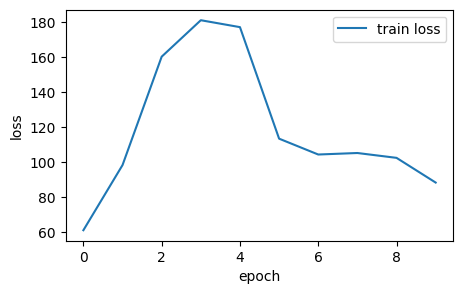

In [30]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(bert_loss, label = 'train loss')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

## 5. BERT Inference

### 5.1 Save the model

In [31]:
save_bert_path = './model/bert.pth'
torch.save(model.state_dict(), save_bert_path)

### 5.2 Load the model

In [32]:
loaded_model = BERT()
loaded_model.load_state_dict(torch.load(save_bert_path))
loaded_model.eval()

BERT(
  (embedding): Embedding(
    (tok_embed): Embedding(84, 768)
    (pos_embed): Embedding(300, 768)
    (seg_embed): Embedding(2, 768)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (enc_self_attn): MultiHeadAttention(
        (W_Q): Linear(in_features=768, out_features=512, bias=True)
        (W_K): Linear(in_features=768, out_features=512, bias=True)
        (W_V): Linear(in_features=768, out_features=512, bias=True)
      )
      (pos_ffn): PoswiseFeedForwardNet(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (fc): Linear(in_features=768, out_features=768, bias=True)
  (activ): Tanh()
  (linear): Linear(in_features=768, out_features=768, bias=True)
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
  (decoder)

# Sentence BERT

## 1. Load Datasets

In [97]:
snli_dataset = load_dataset('snli')

In [98]:
snli_dataset

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
})

In [99]:
snli_dataset['train'].features

{'premise': Value(dtype='string', id=None),
 'hypothesis': Value(dtype='string', id=None),
 'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None)}

In [100]:
# Checking class in 'label'
np.unique(snli_dataset['train']['label'])

array([-1,  0,  1,  2])

In [101]:
# Remove class -1
snli_dataset = snli_dataset.filter(lambda x: 0 if x['label'] == -1 else 1)
# Recheck the class in 'label'
np.unique(snli_dataset['train']['label'])

array([0, 1, 2])

In [102]:
snli_dataset

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 9824
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 549367
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 9842
    })
})

In [103]:
# Reduce the size of snli_dataset
from datasets import DatasetDict
snli_dataset = DatasetDict({
    'train': snli_dataset['train'].shuffle(seed=SEED).select(list(range(4))),
    'test': snli_dataset['test'].shuffle(seed=SEED).select(list(range(4))),
    'validation': snli_dataset['validation'].shuffle(seed=SEED).select(list(range(4)))
})
snli_dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 4
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 4
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 4
    })
})

## 2. Preprocessing

In [104]:
# Create the preprocessing function
def preprocess(raw_texts):
    nlp = spacy.load("en_core_web_md")
    doc = nlp(raw_texts)
    sentences = list(doc.sents)
    if len(sentences)>10:
        sentences = sentences[:10].copy()
    # lowercase the text
    text = [sent.text.lower() for sent in sentences]
    # Remove the symbols
    text = [re.sub("[.,!?\\-]", '', x) for x in text]
    # combine everything into one to make vocabs
    word_list = list(set(" ".join(text).split()))
    word2id = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}  #special tokens.

    #create the word2id
    for i, w in enumerate(word_list):
        word2id[w] = i + 4  #because 0-3 are already occupied
    id2word = {i: w for i, w in enumerate(word2id)}
    vocab_size = len(word2id)

    #list of all tokens for whole text
    token_list = list()
    for sentence in sentences:
        arr = [word2id[word] for sentence in text for word in sentence.split()]
        token_list.append(arr)
    
    return token_list, word2id, id2word, vocab_size

In [105]:
# Revised the make batch function
def make_batch(sentence, batch_size, max_mask, max_len):
    token_list,word2id,id2word,vocab_size = preprocess(" ".join(sentence))
    batch = []
    positive = negative = 0
    while positive != batch_size // 2 or negative != batch_size // 2:

        #randomly choose two sentence
        tokens_a_index, tokens_b_index = randrange(len(token_list)), randrange(len(token_list))
        tokens_a, tokens_b            = token_list[tokens_a_index], token_list[tokens_b_index]

        #1. token embedding - add CLS and SEP
        input_ids = [word2id['[CLS]']] + tokens_a + [word2id['[SEP]']] + tokens_b + [word2id['[SEP]']]

        #2. segment embedding - which sentence is 0 and 1
        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        #3 masking
        n_pred = min(max_mask, max(1, int(round(len(input_ids) * 0.15))))
        #get all the pos excluding CLS and SEP
        candidates_masked_pos = [i for i, token in enumerate(input_ids) if token != word2id['[CLS]']
                                 and token != word2id['[SEP]']]
        shuffle(candidates_masked_pos)
        masked_tokens, masked_pos = [], []
        #simply loop and mask accordingly
        for pos in candidates_masked_pos[:n_pred]:
            masked_pos.append(pos)
            masked_tokens.append(input_ids[pos])
            if random() < 0.1:  #10% replace with random token
                index = randint(0, vocab_size - 1)
                input_ids[pos] = word2id[id2word[index]]
            elif random() < 0.8:  #80 replace with [MASK]
                input_ids[pos] = word2id['[MASK]']
            else:
                pass

        #4. pad the sentence to the max length
        n_pad = max_len - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        #5. pad the mask tokens to the max length
        if max_mask > n_pred:
            n_pad = max_mask - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        #6. check whether is positive or negative
        if tokens_a_index + 1 == tokens_b_index and positive < batch_size / 2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True])
            positive += 1
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size / 2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False])
            negative += 1

    return batch

In [106]:
def preprocess_datasets(datasets,max_mask=5,max_len=300):
    # preprocess the dataset
    sentences = [f"{premise}{hypothesis}"for premise,hypothesis in zip(datasets["premise"],datasets["hypothesis"])]
    # make the batch
    batch = make_batch(sentences,len(sentences),max_mask,max_len)
    return {
        "input_ids": torch.tensor([i[0] for i in batch]),
        "segment_ids": torch.tensor([i[1] for i in batch]),
        "masked_tokens": torch.tensor([i[2] for i in batch]),
        "masked_pos": torch.tensor([i[3] for i in batch]),
        "labels": torch.tensor([i[4] for i in batch], dtype=torch.long)
    }

In [107]:
# preprocessing the snli_dataset
batch_size = 6
tokenized_snli_dataset = snli_dataset.map(preprocess_datasets,batched=True)

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

In [108]:
# Separate the tokenization of premise and hypothesis
premise_dataset = tokenized_snli_dataset.map(lambda x: {'input_ids': x['input_ids'], 
                                                        'segment_ids': x['segment_ids'], 
                                                        'masked_tokens': x['masked_tokens'], 
                                                        'masked_pos': x['masked_pos'], 
                                                        'labels': x['labels']})
hypothesis_dataset = tokenized_snli_dataset.map(lambda x: {'input_ids': x['input_ids'], 
                                                           'segment_ids': x['segment_ids'], 
                                                           'masked_tokens': x['masked_tokens'], 
                                                           'masked_pos': x['masked_pos'], 
                                                           'labels': x['labels']})


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

In [109]:
# Remove opposite dataset columns
premise_dataset = premise_dataset.remove_columns(['hypothesis'])
hypothesis_dataset = hypothesis_dataset.remove_columns(['premise'])

In [110]:
premise_dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'label', 'input_ids', 'segment_ids', 'masked_tokens', 'masked_pos', 'labels'],
        num_rows: 4
    })
    test: Dataset({
        features: ['premise', 'label', 'input_ids', 'segment_ids', 'masked_tokens', 'masked_pos', 'labels'],
        num_rows: 4
    })
    validation: Dataset({
        features: ['premise', 'label', 'input_ids', 'segment_ids', 'masked_tokens', 'masked_pos', 'labels'],
        num_rows: 4
    })
})

In [111]:
hypothesis_dataset

DatasetDict({
    train: Dataset({
        features: ['hypothesis', 'label', 'input_ids', 'segment_ids', 'masked_tokens', 'masked_pos', 'labels'],
        num_rows: 4
    })
    test: Dataset({
        features: ['hypothesis', 'label', 'input_ids', 'segment_ids', 'masked_tokens', 'masked_pos', 'labels'],
        num_rows: 4
    })
    validation: Dataset({
        features: ['hypothesis', 'label', 'input_ids', 'segment_ids', 'masked_tokens', 'masked_pos', 'labels'],
        num_rows: 4
    })
})

In [112]:
# Format -> Pytorch
premise_dataset.set_format("torch")
hypothesis_dataset.set_format("torch")

## 3. Data Loader

In [113]:
# Data Loader for primise dataset
premise_loader_train = DataLoader(premise_dataset['train'],batch_size=batch_size,shuffle=True)
premise_loader_test = DataLoader(premise_dataset['test'],batch_size=batch_size)
premise_loader_valid = DataLoader(premise_dataset['validation'],batch_size=batch_size)
# Data Loader for hypothesis dataset
hypothesis_loader_train = DataLoader(hypothesis_dataset['train'],batch_size=batch_size,shuffle=True)
hypothesis_loader_test = DataLoader(hypothesis_dataset['test'],batch_size=batch_size)
hypothesis_loader_valid = DataLoader(hypothesis_dataset['validation'],batch_size=batch_size)

In [114]:
# Pick one loader and check
for batch in premise_loader_train:
    print(len(batch['premise']))
    print(batch['label'].shape)
    print(batch['input_ids'].shape)
    print(batch['segment_ids'].shape)
    print(batch['masked_tokens'].shape)
    print(batch['masked_pos'].shape)
    print(batch['labels'].shape)
    break

4
torch.Size([4])
torch.Size([4, 300])
torch.Size([4, 300])
torch.Size([4, 5])
torch.Size([4, 5])
torch.Size([4])


In [115]:
# Pick one loader and check
for batch in hypothesis_loader_train:
    print(len(batch['hypothesis']))
    print(batch['label'].shape)
    print(batch['input_ids'].shape)
    print(batch['segment_ids'].shape)
    print(batch['masked_tokens'].shape)
    print(batch['masked_pos'].shape)
    print(batch['labels'].shape)
    break

4
torch.Size([4])
torch.Size([4, 300])
torch.Size([4, 300])
torch.Size([4, 5])
torch.Size([4, 5])
torch.Size([4])


## 4. S-BERT Model

In [116]:
load_path = './model/bert.pth'
loaded_model = BERT()
loaded_model.load_state_dict(torch.load(load_path))
loaded_model

BERT(
  (embedding): Embedding(
    (tok_embed): Embedding(84, 768)
    (pos_embed): Embedding(300, 768)
    (seg_embed): Embedding(2, 768)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (enc_self_attn): MultiHeadAttention(
        (W_Q): Linear(in_features=768, out_features=512, bias=True)
        (W_K): Linear(in_features=768, out_features=512, bias=True)
        (W_V): Linear(in_features=768, out_features=512, bias=True)
      )
      (pos_ffn): PoswiseFeedForwardNet(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (fc): Linear(in_features=768, out_features=768, bias=True)
  (activ): Tanh()
  (linear): Linear(in_features=768, out_features=768, bias=True)
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
  (decoder)

## 5. Loss Function

In [117]:
def configurations(u,v):
    uv = torch.sub(u, v)   # batch_size,hidden_dim
    uv_abs = torch.abs(uv) # batch_size,hidden_dim
    x = torch.cat([u, v, uv_abs], dim=-1) # batch_size, 3*hidden_dim
    return x

def cosine_similarity(u, v):
    dot_product = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    similarity = dot_product / (norm_u * norm_v)
    return similarity

In [118]:
classifier_head = torch.nn.Linear(768*3, 3)
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=2e-4)
optimizer_classifier = torch.optim.Adam(classifier_head.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

In [119]:
#!pip install transformers

In [120]:
from transformers import get_linear_schedule_with_warmup
# warmup for the first ~10% steps
total_steps = int(len(snli_dataset) / batch_size)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
		optimizer, num_warmup_steps=warmup_steps,
  	num_training_steps=total_steps - warmup_steps
)
# then during the training loop we update the scheduler per step
scheduler.step()
scheduler_classifier = get_linear_schedule_with_warmup(
		optimizer_classifier, num_warmup_steps=warmup_steps,
  	num_training_steps=total_steps - warmup_steps
)
# then during the training loop we update the scheduler per step
scheduler_classifier.step()

## 6. Training S-BERT

In [130]:
def train(model, classifier_head, premise_loader_train, hypothesis_loader_train, optimizer, optimizer_classifier, scheduler, scheduler_classifier, criterion):
    epoch_loss = []
    model.train()
    classifier_head.train()

    for step, (premise_batch, hypothesis_batch) in enumerate(tqdm(zip(premise_loader_train, hypothesis_loader_train), leave=True, desc='Training: ')):
        # zero all gradients on each new step
        optimizer.zero_grad()
        optimizer_classifier.zero_grad()
        # premise
        input_ids_premise = premise_batch['input_ids']
        segment_ids_premise = premise_batch['segment_ids']
        masked_tokens_premise = premise_batch['masked_tokens']
        masked_pos_premise = premise_batch['masked_pos']
        labels_premise = premise_batch['labels']
        # hypothesis
        input_ids_hypothesis = hypothesis_batch['input_ids']
        segment_ids_hypothesis = hypothesis_batch['segment_ids']
        masked_tokens_hypothesis = hypothesis_batch['masked_tokens']
        masked_pos_hypothesis = hypothesis_batch['masked_pos']
        labels_hypothesis = hypothesis_batch['labels']
        # Extract token embeddings from BERT at last_hidden_state
        _,_,u = model(input_ids_premise, segment_ids_premise,masked_pos_premise)
        _,_,v = model(input_ids_hypothesis, segment_ids_hypothesis,masked_pos_hypothesis)

        # |u-v| tensor
        uv = torch.sub(u, v)
        uv_abs = torch.abs(uv)

        # Concatenate u, v, |u-v|
        x = torch.cat([u, v, uv_abs], dim=-1)

        # Process concatenated tensor through classifier_head
        x = classifier_head(x)

       # calculate the 'softmax-loss' between predicted and true label
        loss = criterion(x, labels_premise)
        
        # using loss, calculate gradients and then optimizerize
        loss.backward()
        epoch_loss.append(loss.item())
        optimizer.step()
        optimizer_classifier.step()

        scheduler.step() # update learning rate scheduler
        scheduler_classifier.step()

    return np.mean(epoch_loss)

In [131]:
def evaluate(model, classifier_head, premise_loader_valid,hypothesis_loader_valid, criterion):
    epoch_loss = []
    model.eval()
    classifier_head.eval()

    with torch.no_grad():
        for step, (premise_batch, hypothesis_batch) in enumerate(tqdm(zip(premise_loader_valid, hypothesis_loader_valid), leave=True, desc='Evaluate: ')):
            
            # premise
            input_ids_premise = premise_batch['input_ids']
            segment_ids_premise = premise_batch['segment_ids']
            masked_tokens_premise = premise_batch['masked_tokens']
            masked_pos_premise = premise_batch['masked_pos']
            labels_premise = premise_batch['labels']
            # hypothesis
            input_ids_hypothesis = hypothesis_batch['input_ids']
            segment_ids_hypothesis = hypothesis_batch['segment_ids']
            masked_tokens_hypothesis = hypothesis_batch['masked_tokens']
            masked_pos_hypothesis = hypothesis_batch['masked_pos']
            labels_hypothesis = hypothesis_batch['labels']
            # Extract token embeddings from BERT at last_hidden_state
            _,_,u = model(input_ids_premise, segment_ids_premise,masked_pos_premise)
            _,_,v = model(input_ids_hypothesis, segment_ids_hypothesis,masked_pos_hypothesis)
            
           
          
            # build the |u-v| tensor
            uv = torch.sub(u, v)   # batch_size,hidden_dim
            uv_abs = torch.abs(uv) # batch_size,hidden_dim
            
            # concatenate u, v, |u-v|
            x = torch.cat([u, v, uv_abs], dim=-1) # batch_size, 3*hidden_dim
            
            # process concatenated tensor through classifier_head
            x = classifier_head(x) #batch_size, classifer
            
            # calculate the 'softmax-loss' between predicted and true label
            loss = criterion(x, labels_premise)
            epoch_loss.append(loss.item())

    return np.mean(epoch_loss)

In [133]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [154]:
num_epoch = 5

best_val_loss = float('inf')
train_losses = []
val_losses = []

# 1 epoch should be enough, increase if wanted
for epoch in range(num_epoch):
    start_time = time.time()
    train_loss = train(loaded_model, classifier_head, premise_loader_train, hypothesis_loader_train, optimizer, optimizer_classifier, scheduler, scheduler_classifier, criterion)
    val_loss = evaluate(loaded_model, classifier_head, premise_loader_valid, hypothesis_loader_valid, criterion)

    #for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the model only when its validation loss is lower than all its predecessors
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(classifier_head, './model/s_bert_classifier_head.pt')  # save the classifier head
        torch.save(model.state_dict(), './model/s_bert.pth')  # save the model's parameters and state to a file
        
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}')

Training: : 1it [00:03,  3.67s/it]
Evaluate: : 1it [00:01,  1.06s/it]


Epoch: 01 | Time: 0m 4s
	Train Loss: 1.109
	 Val. Loss: 1.113


Training: : 1it [00:04,  4.66s/it]
Evaluate: : 1it [00:01,  1.07s/it]


Epoch: 02 | Time: 0m 5s
	Train Loss: 1.113
	 Val. Loss: 1.128


Training: : 1it [00:04,  4.53s/it]
Evaluate: : 1it [00:00,  1.02it/s]


Epoch: 03 | Time: 0m 5s
	Train Loss: 1.113
	 Val. Loss: 1.113


Training: : 1it [00:04,  4.86s/it]
Evaluate: : 1it [00:01,  1.08s/it]


Epoch: 04 | Time: 0m 5s
	Train Loss: 1.113
	 Val. Loss: 1.113


Training: : 1it [00:04,  4.10s/it]
Evaluate: : 1it [00:00,  1.04it/s]

Epoch: 05 | Time: 0m 5s
	Train Loss: 1.107
	 Val. Loss: 1.113


In [168]:
loaded_model.eval()
classifier_head.eval()
total_similarity = 0
with torch.no_grad():
    for step, (premise_batch, hypothesis_batch) in enumerate(zip(premise_loader_valid, hypothesis_loader_valid)):
         # premise
            input_ids_premise = premise_batch['input_ids']
            segment_ids_premise = premise_batch['segment_ids']
            masked_tokens_premise = premise_batch['masked_tokens']
            masked_pos_premise = premise_batch['masked_pos']
            labels_premise = premise_batch['labels']
            # hypothesis
            input_ids_hypothesis = hypothesis_batch['input_ids']
            segment_ids_hypothesis = hypothesis_batch['segment_ids']
            masked_tokens_hypothesis = hypothesis_batch['masked_tokens']
            masked_pos_hypothesis = hypothesis_batch['masked_pos']
            labels_hypothesis = hypothesis_batch['labels']
            # Extract token embeddings from BERT at last_hidden_state
            _,_,u = loaded_model(input_ids_premise, segment_ids_premise,masked_pos_premise)
            _,_,v = loaded_model(input_ids_hypothesis, segment_ids_hypothesis,masked_pos_hypothesis)

    similarity_score = cosine_similarity(u.reshape(-1), v.reshape(-1))
    total_similarity += similarity_score
    
average_similarity = total_similarity / (len(premise_loader_valid)+len(hypothesis_loader_valid))
print(f"Avg Cosine Similarity: {average_similarity:.4f}")

Avg Cosine Similarity: 0.5000


# Evaluation and Analysis

## 1. Download Pre-trained model

In [ ]:
#!pip install -U sentence-transformers

In [164]:
from sentence_transformers import SentenceTransformer
hf_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [165]:
hf_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

## 2. Comparison

In [188]:
# Sentences we want to encode. Example:
sentences = ["The cat sat on the mat by the door.", "The dog walk on the mat by the door."]

# Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

In [189]:
# Hugging face model
u_hug = torch.tensor(embeddings[0], dtype=torch.float32)
v_hug = torch.tensor(embeddings[1], dtype=torch.float32)

# cosine similarity
cos_sim = cosine_similarity(u_hug.reshape(1, -1), v_hug.reshape(1, -1))[0, 0]
print(f'Cosine similarity: {cos_sim}')

Cosine similarity: 0.6528433561325073


In [170]:
from sklearn.metrics.pairwise import cosine_similarity
import torchtext
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [236]:
import re

def inputs(sentence, tokenizer, vocab, max_len):
    # Tokenize the input sentence
    tokens = tokenizer(re.sub("[.,!?\\-]", '', sentence.lower()))
    
    # Filter tokens that are not in the vocabulary
    tokens = [token for token in tokens if token in vocab]
    
    # Add special tokens ([CLS] and [SEP]) and convert tokens to their corresponding IDs
    input_ids = [vocab['[CLS]']] + [vocab[token] for token in tokens] + [vocab['[SEP]']]
    
    # Pad input_ids with 0s if its length is less than max_len
    n_pad = max_len - len(input_ids)
    input_ids += [0] * n_pad
    
    # Generate attention mask
    attention_mask = [1] * len(input_ids)
    
    return {'input_ids': torch.LongTensor(input_ids).reshape(1, -1),
            'attention_mask': torch.LongTensor(attention_mask).reshape(1, -1)}


In [250]:
inputs("I love cat.", tokenizer, word2id, 300)

TypeError: inputs() missing 2 required positional arguments: 'word2id' and 'max_len'

In [211]:
with open('./model/word2id.pickle','rb') as f:
  word2id = pickle.load(f)

In [212]:
import torchtext
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [246]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(model, tokenizer, vocab, sentence_a, sentence_b):
    # Get input IDs and segment IDs for sentence_a
    inputs_a = get_inputs(sentence_a, tokenizer, vocab, max_len)
    input_ids_a = torch.tensor(inputs_a['input_ids']).unsqueeze(0)  # Add batch dimension
    segment_ids = torch.tensor([0] * len(input_ids_a))  # Assuming single segment
    
    # Get input IDs for sentence_b
    inputs_b = get_inputs(sentence_b, tokenizer, vocab, max_len)
    input_ids_b = torch.tensor(inputs_b['input_ids']).unsqueeze(0)  # Add batch dimension
    
    print(input_ids_a.shape,input_ids_b.shape)
    # Get token embeddings for sentence_a and sentence_b
    u = model.get_last_hidden_state(input_ids_a, segment_ids)
    v = model.get_last_hidden_state(input_ids_b, segment_ids)
    
    # Calculate cosine similarity
    similarity_score = cosine_similarity(u.detach().numpy().reshape(1, -1), v.detach().numpy().reshape(1, -1))[0, 0]
    
    return similarity_score


In [247]:
sentence_a = 'Your contribution helped make it possible for us to provide our students with a quality education.'
sentence_b = "Your contributions were of no help with our students' education."
similarity = calculate_similarity(loaded_model, tokenizer, word2id, sentence_a, sentence_b)
print(f"Cosine Similarity: {similarity:.4f}")

torch.Size([1, 1, 300]) torch.Size([1, 1, 300])


C:\Users\earth\AppData\Local\Temp\ipykernel_14320\642347818.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids_a = torch.tensor(inputs_a['input_ids']).unsqueeze(0)  # Add batch dimension
C:\Users\earth\AppData\Local\Temp\ipykernel_14320\642347818.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids_b = torch.tensor(inputs_b['input_ids']).unsqueeze(0)  # Add batch dimension


ValueError: too many values to unpack (expected 2)